<a href="https://colab.research.google.com/github/kand11/MfPSI/blob/main/Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pymorphy3 pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 30.0 MB/s eta 0:00:00


In [2]:
import pymorphy3
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split


nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
def lemmatize(text):
  morph = pymorphy3.MorphAnalyzer()
  tokens = word_tokenize(text)
  return [morph.parse(word)[0].normal_form for word in tokens if not word in set(stopwords.words("russian"))]


In [4]:
def tokenize(text):
  tokens = word_tokenize(text)
  return tokens


In [5]:
#Подсчет для каждого текста кол-во встреч. слов
def word_frequency_matrix(texts, unique_words):
    word_index = {word: i for i, word in enumerate(unique_words)}

    matrix = []
    for text in texts:
      row = [0] * len(unique_words)
      for word in text:
          row[word_index[word]] += 1
      matrix.append(row)

    return matrix


In [6]:
#TF-IDF
def tf_idf(texts, matrix, non_zero, unique_words):
    word_index = {word: i for i, word in enumerate(unique_words)}
    tf_matrix = []

    for i, text in enumerate(texts):
        len_text = len(text) if len(text) > 0 else 1
        row = [0] * len(unique_words)
        for word in text:
            row[word_index[word]] = (matrix[i][word_index[word]] / len_text) * non_zero [word_index[word]]
        tf_matrix.append(row)

    return tf_matrix

In [7]:
df = pd.read_csv('train.csv')

#Берем 500 строк, весь файл за 1.5 часа не обработался(проверено экспериментальным путем)
df = df.head(500)

print(df)

           oid      category  \
0    365271984  winter_sport   
1    503385563       extreme   
2    146016084      football   
3    933865449    boardgames   
4    713550145        hockey   
..         ...           ...   
495  994336942    boardgames   
496  940639075    boardgames   
497  280447096      football   
498  365122898     autosport   
499  434434151        hockey   

                                                  text  
0    Волшебные фото Виктория Поплавская ЕвгенияМедв...  
1    Возвращение в подземелье Треша 33 Эйфория тупо...  
2    Лучшие чешские вратари – Доминик Доминатор Гаш...  
3    Rtokenoid Warhammer40k валрак решил нас подкор...  
4    Шестеркин затаскивает Рейнджерс в финал Восточ...  
..                                                 ...  
495  Майские все ближе 33 И как все знают отдыхать ...  
496  Трехмерные поля для настольных ролевых игр от ...  
497  Субименди откажет Барсе и подпишет новый контр...  
498  Рекорды Формулы 1 количество сезонов до 

In [8]:
#Лемматизация
df['lemmatized_text'] = df['text'].apply(lambda x: lemmatize(x))

In [9]:
#Токенизация
lemm_text = [tokenize(re.sub("[^\w\s]", ""," ".join(text))) for text in df['lemmatized_text']]

#Уникальные слова
res = [item for sublist in lemm_text for item in sublist]
unique_words = sorted(set(res))

#Частотная матрица
matrix = word_frequency_matrix(lemm_text, unique_words)

#IDF
transposed = [list(col) for col in zip(*matrix)]
non_zero_counts = [sum(1 for num in row if num != 0) for row in transposed]

#TF-IDF
X = tf_idf(lemm_text, matrix, non_zero_counts, unique_words)

In [10]:
#Целевая переменная (категории)
y = df['category']

#Кластеризация
kmeans = KMeans(n_clusters=df['category'].nunique(), random_state=42)
clusters = kmeans.fit_predict(X)

#Сравнение кластеров с реальными метками (было бы неплохо улучшить..)
ari = adjusted_rand_score(y, clusters)
print(f"Adjusted Rand Index (сходство кластеров и реальных меток): {ari:.4f}")

#Разделение на train / val / test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Adjusted Rand Index (сходство кластеров и реальных меток): 0.0029
Train size: 300
Validation size: 100
Test size: 100


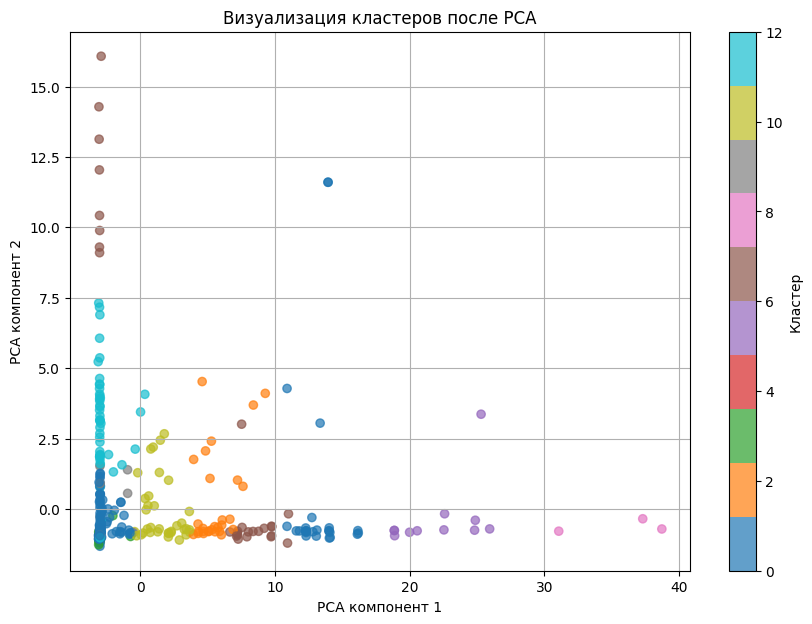

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Снижение размерности до 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)

# Отображение кластеров
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title('Визуализация кластеров после PCA')
plt.xlabel('PCA компонент 1')
plt.ylabel('PCA компонент 2')
plt.colorbar(scatter, label='Кластер')
plt.grid(True)
plt.show()

Видно группы кластеров. Они выглядят немного плотно и локально.

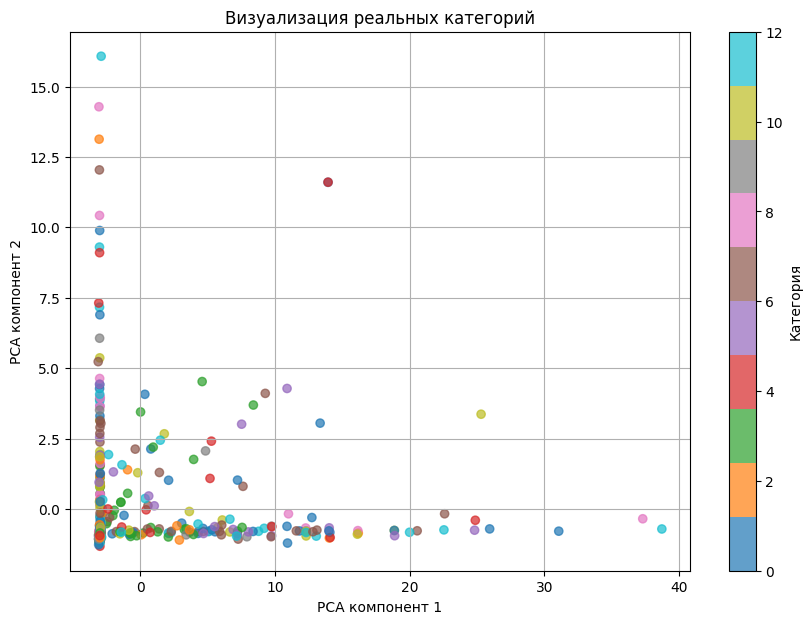

In [12]:
plt.figure(figsize=(10, 7))
scatter2 = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=pd.factorize(y)[0], cmap='tab10', alpha=0.7)
plt.title('Визуализация реальных категорий')
plt.xlabel('PCA компонент 1')
plt.ylabel('PCA компонент 2')
plt.colorbar(scatter2, label='Категория')
plt.grid(True)
plt.show()

- Сильное наложение цветов (категорий) говорит о том, что тексты из разных классов часто имеют похожее векторное представление (TF-IDF). Это объясняет, почему кластеризация работает не идеально.
- Мало чётко отделённых областей — только несколько точек явно выделяются (например, справа или вверху), возможно, это тексты с уникальной лексикой или темой.

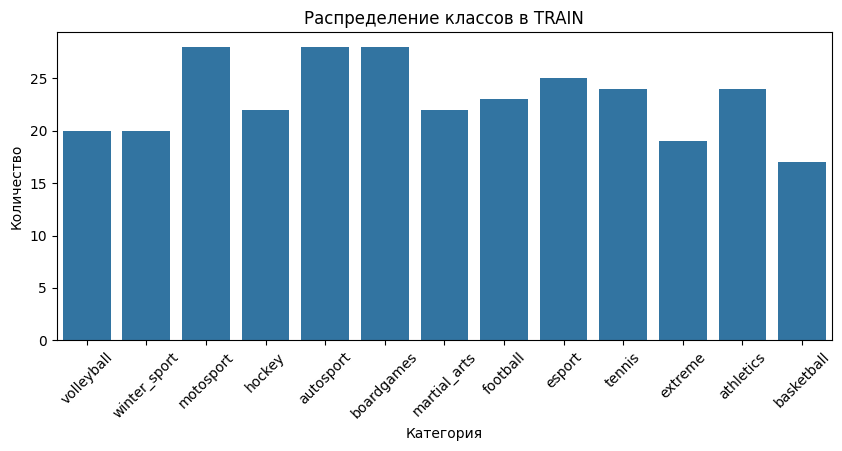

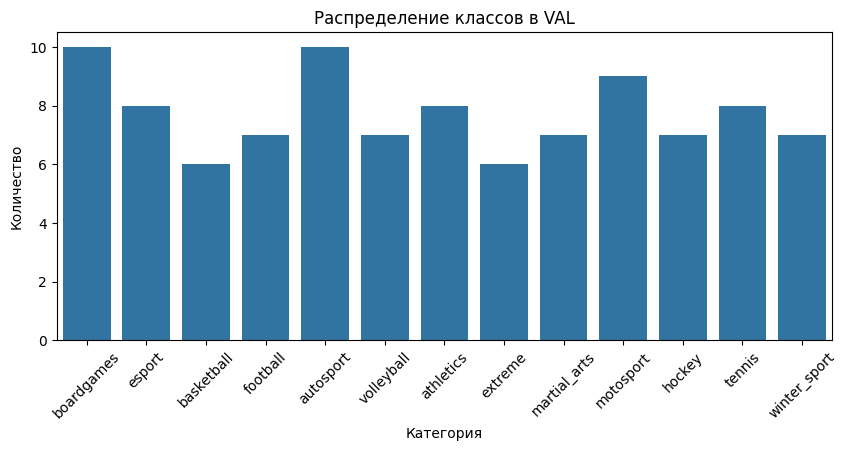

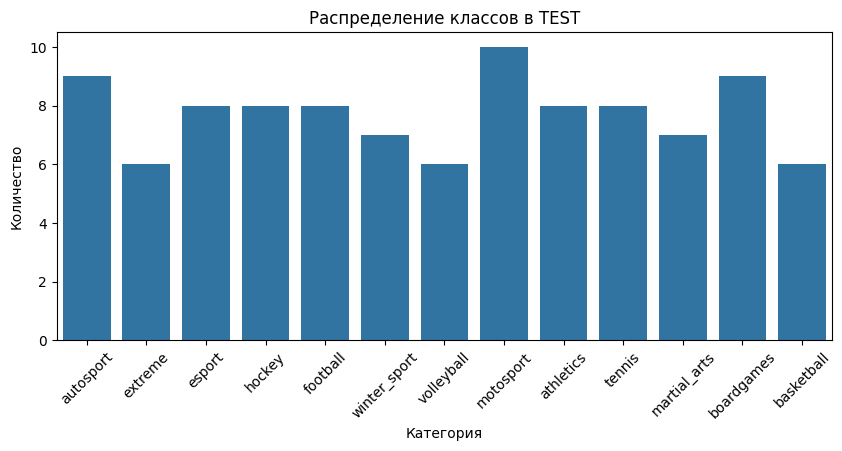

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(y, title):
    plt.figure(figsize=(10, 4))
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Категория')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(y_train, "Распределение классов в TRAIN")
plot_class_distribution(y_val, "Распределение классов в VAL")
plot_class_distribution(y_test, "Распределение классов в TEST")

В выборках видно по 3 выделяющиеся категории (autosport, motosport, boardgames). Значит выборки получились хорошими

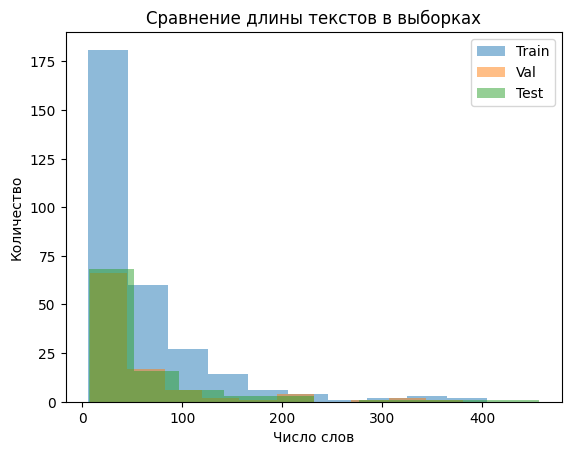

In [14]:
df['length'] = df['text'].apply(lambda x: len(x.split()))

plt.hist(df.loc[y_train.index, 'length'], alpha=0.5, label='Train')
plt.hist(df.loc[y_val.index, 'length'], alpha=0.5, label='Val')
plt.hist(df.loc[y_test.index, 'length'], alpha=0.5, label='Test')
plt.legend()
plt.title('Сравнение длины текстов в выборках')
plt.xlabel('Число слов')
plt.ylabel('Количество')
plt.show()

Вроде как графики отличаются только "масштабом", но это можно объяснить объемом выборок.